# Energy-Based Models

## Conceptual overview
Machine learning models pair an input X to an output Y. The degree to which the model matches the data is assigned a number called the energy for each possible pairing of X and Y. A low energy means X and Y are a good match and low energy means they are a poor match. Once a function is found to map the input to the output, it is then straightforward to search for the lowest Y for any given X. This search for the minimum energy is called inference.

The parameters of the energy function can be adjusted such that correct outputs have lower energy than incorrect ones. This is called learning.

Energy-based models are a general categorisation which includes logstic regression, support vector machines and conditional random fields, as well as generativeve  models like Boltzmann Machines. EBMs are distinct from probablistic models in that they are not required to output nomalised probability distributions. This is an advantage of EBMs as for this reason they avoid heavy computations, but they also are alke to produce proabilities if needed.

The naming of the loss function as energy may seem like a stretch, but in reality EBMs are heavily derived from statistical mechanics. The probability of a system being in a particular physical state is given by the Boltzmann distribution
$$

P(s) = \frac{e^{-\beta E(s)}}{Z}

$$
where the "state" $s$ in EBMs corresponds to a configuration of data and prediction (X,Y). Lower energy states are more likely, and the partition function (sum over states) normalises the probabilities. The Ising model, which in physics describes interacting spins, is a special case of an EBM. A Restricted Boltzmann Machine is mathematically very similar to an Ising system.

## Training with Contrastive Divergence
We want to train an EBM by adjusting its parameters such that the energy is low for correct outputs and high for incorrect ones. To know by how much to change the parameters, we must calculate the gradient of the logarithm of the probability given by the Boltzmann distribution to see how the model currently "thinks" data is distributed. This though, would require that we calculate the expected value of all of the possible states weighted by their probabilities 
$$
\mathbb{E}_{P_{\text{model}}} \left[ \frac{\partial}{\partial W} E(X, Y; W) \right],
$$

which is impossible for complex models.

To get around this, we can instead approximate the gradient by randomly sampling the model distribution. We must use Gibbs sampling as our distribution is complex. Gibbs sampling is a form of Markov Chain Monte Carlo method and works by updating each variable in turn, sampling it from its conditional probability given all other variables. For example, for variable $Y_i$
$$
Y_i \sim P\big(Y_i \mid Y_{\setminus i}, X\big) \propto e^{-E(X, Y; W)}
$$
where $Y_{\setminus i}$ means all variables except $Y_i$. By cycling through all variables repeatedly, we generate samples that (after enough steps) come from the true model distribution.

Contrastive divergence training starts with a real data sample $(X,Y^{(0)})$ and then runs $k$ steps of Gibbs sampling on it to reconstruct the data ($Y^{(k)}$). The parameters are then updated such that the energy of the real data is lowered and that is the reconstructed sample is raised:
$$
\frac{\partial \mathcal{L}}{\partial W}
\approx
- \frac{\partial}{\partial W} E(X, Y^{(0)}; W)
+ \frac{\partial}{\partial W} E(X, Y^{(k)}; W)
$$
This is then repeated for many models.

In the limit, Gibbs sampling will converge to the true data, but for good results $k$ can be very small, often even just 1.

## Inference in EBMs
When training is done, an EBM can be used to predict outputs.
The goal of inference is:
$$
Y^* = \arg\min_Y E(X, Y; W)
$$
This means: given an input X, we want to find the output Y* that has the lowest energy under the learned model. This can be difficult as the energy function can have many local minima and many dimensions. We can get around this though by again using Gibbs sampling and just pick the sample with the lowest energy.

## Restricted Boltzmann Machines
A Restricted Boltzmann Machine is a type of EBM that learns a probability distribution over a set of variables. An RMB consists of visible units $v$ which represent the observed data (e.g. image pixels), and hidden units $h$, the latent variables. Thus they have two layers. They are restricted because there are no connections between units in the same layer. Visible units only connect to hidden units, and vice versa. This greatly simplifies inference as the conditional distributions factorise, so Gibbs sampling can be used. The energy function is
$$
E(v, h; W, a, b) = -a^\top v - b^\top h - v^\top W h
$$
where $W$ is the weight matrix beween $v$ and $h$, and $a$ and $b$ are their bias vectors

## The Ising Model
The Ising Model is one of the simplest models in statistical physics that also is an example of an EBM. It was developed to describe ferromagnetism, where spins are labelled up and down. The total energy of the system is
$$
E(\mathbf{s}) = -J \sum_{\langle i, j \rangle} s_i s_j - h \sum_{i} s_i
$$
where $J$ is the interaction strength between neighboring spins, $h$ is the external magnetic field, and ${\langle i, j \rangle}$ mean to sum over neigbouring pairs. This physical system naturally defines a probability distribution (the Boltzmann distribution) which is the principle EBMs use to model data.

The Ising model is a special Boltzmann Machine with local pairwise interactions. In this way, the Ising model can be viewed as the minimal form of an EBM: binary units with local couplings, governed by the same Boltzmann distribution used in RBMs.

# RBM Implementation

We will now go through an example of an energy based model and implement a restricted Boltzmann machine and train it on the MNIST dataset of handwritten digits. First we must import some packages.

In [ ]:
# Setup
import torch
import torch.nn as nn
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

The next section defines the RBM model as a PyTorch neural network module. The RBM consists of visible units (input layer) and hidden units (latent layer), connected by weights and biases. The class includes methods to sample hidden states given visible states, sample visible states given hidden states, perform Gibbs sampling, and update the model parameters using contrastive divergence.

In [ ]:
# Now define a simple energy-based model: The Restricted Boltzmann Machine
class RBM(nn.Module):
    def __init__(self, n_visible, n_hidden):
        super().__init__()
        self.W = nn.Parameter(torch.randn(n_visible, n_hidden) * 0.01)  # weights
        self.a = nn.Parameter(torch.zeros(n_visible))  # visible bias
        self.b = nn.Parameter(torch.zeros(n_hidden))   # hidden bias
    
    # Sample hidden layer given visible layer
    def sample_h(self, v):
        prob_h = torch.sigmoid(torch.matmul(v, self.W) + self.b)
        return prob_h, torch.bernoulli(prob_h)
    
    # Sample visible layer given hidden layer
    def sample_v(self, h):
        prob_v = torch.sigmoid(torch.matmul(h, self.W.t()) + self.a)
        return prob_v, torch.bernoulli(prob_v)
    
    # Gibbs sampling: sample visible layer from visible layer
    # and hidden layer from hidden layer
    def gibbs_sampling(self, v, k=1):
        v_k = v
        for _ in range(k):
            _, h_k = self.sample_h(v_k)
            _, v_k = self.sample_v(h_k)g
        return v_k
    
    # Contrastive Divergence: update weights and biases
    # using the difference between positive and negative phases
    def contrastive_divergence(self, v, lr=0.1):
        prob_h0, h0 = self.sample_h(v) 
        prob_v1, v1 = self.sample_v(h0)
        prob_h1, h1 = self.sample_h(v1)
        # Calculate gradients
        positive_grad = torch.matmul(v.t(), prob_h0)
        negative_grad = torch.matmul(v1.t(), prob_h1)
        # Update weights and biases
        self.W.data += lr * (positive_grad - negative_grad) / v.size(0)
        self.a.data += lr * torch.mean(v - v1, dim=0)
        self.b.data += lr * torch.mean(prob_h0 - prob_h1, dim=0)



This part sets up the MNIST dataset. The images are first converted to PyTorch tensors and then given a value of 0 or 1. The dataset is loaded in batches and shuffled for efficient training.

In [ ]:
# Load MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: (x > 0.5).float())  # binarise pixels
])

mnist_train = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(mnist_train, batch_size=64, shuffle=True)

Here, we create an RBM with 784 visible units (corresponding to the 28×28 pixels) and 128 hidden units. The training loop runs for a specified number of epochs, where for each batch of data the RBM parameters are updated using contrastive divergence. This iterative process allows the RBM to gradually adjust its weights and biases to model the data distribution.

In [19]:
# Initialize RBM
rbm = RBM(n_visible=28*28, n_hidden=128)
epochs = 5
lr = 0.1 # Learning rate

# Training loop
for epoch in range(epochs):
    for batch, _ in train_loader: # Get batch of images
        batch = batch.view(-1, 28*28) # Flatten the images
        rbm.contrastive_divergence(batch, lr=lr) # Update RBM parameters
    print(f"Epoch {epoch+1} done.")


Epoch 1 done.
Epoch 2 done.
Epoch 3 done.
Epoch 4 done.
Epoch 5 done.


After training, this section reconstructs the images by running several steps of Gibbs sampling starting from the input images. Gibbs sampling alternates between sampling hidden and visible states, which helps the RBM generate samples close to the training data distribution. The reconstruction process shows how well the RBM has learned to represent the input data. Finally, the original and reconstructed images are plotted, giving an intuitive understanding of how well the RBM can recreate the training images.

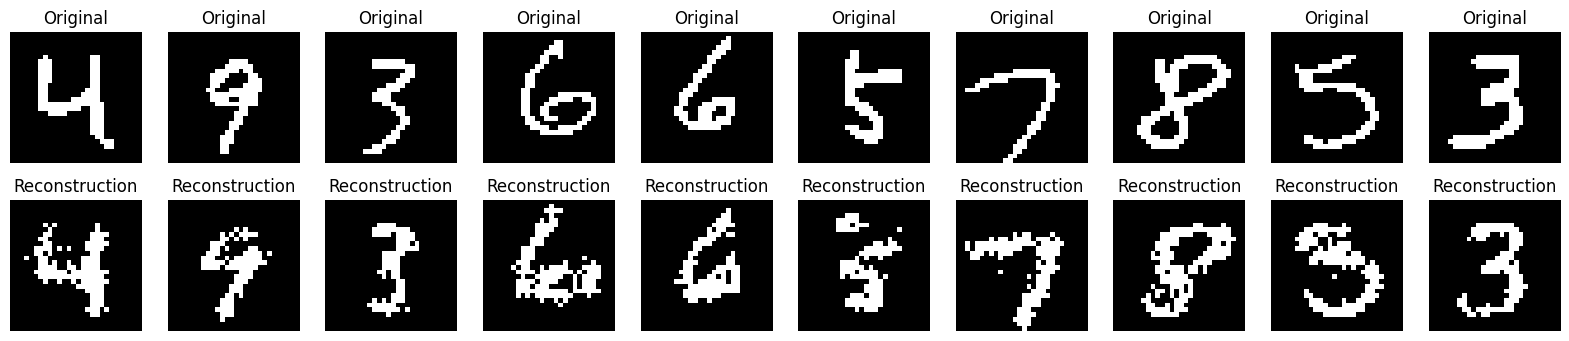

In [20]:
# Plot the reconstruction
def plot_images(orig, recon, n=10):
    plt.figure(figsize=(20,4))
    for i in range(n):
        # Original
        ax = plt.subplot(2, n, i+1)
        plt.imshow(orig[i].reshape(28,28), cmap='gray')
        plt.title("Original")
        plt.axis('off')
        # Reconstruction
        ax = plt.subplot(2, n, i+1+n)
        plt.imshow(recon[i].reshape(28,28), cmap='gray')
        plt.title("Reconstruction")
        plt.axis('off')
    plt.show()

# Get some test data and reconstruct
test_batch, _ = next(iter(train_loader))
test_batch = test_batch.view(-1, 28*28)
reconstructed = rbm.gibbs_sampling(test_batch, k=5).detach()

plot_images(test_batch.numpy(), reconstructed.numpy())

We can improve the quality of the reconstructions by increasing the number of training epochs, increasing the number of hidden units, using more Gibbs sampling steps, tuning the learning rate or initialising with pretrained weights.

Epoch 1 done.
Epoch 2 done.
Epoch 3 done.
Epoch 4 done.
Epoch 5 done.
Epoch 6 done.
Epoch 7 done.
Epoch 8 done.
Epoch 9 done.
Epoch 10 done.
Epoch 11 done.
Epoch 12 done.
Epoch 13 done.
Epoch 14 done.
Epoch 15 done.
Epoch 16 done.
Epoch 17 done.
Epoch 18 done.
Epoch 19 done.
Epoch 20 done.


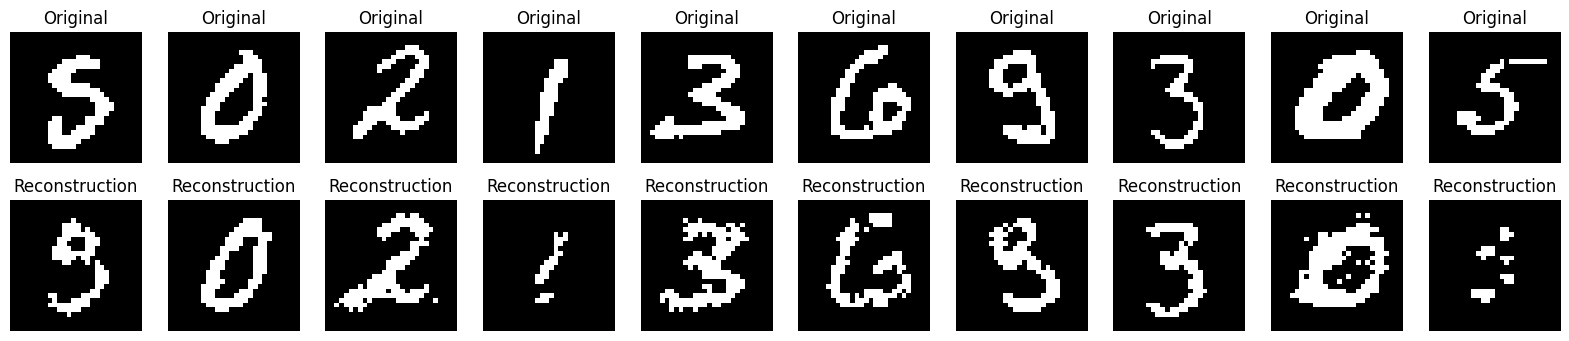

In [23]:
# Improved RBM training and reconstruction with updated parameters

rbm_improved = RBM(n_visible=28*28, n_hidden=192) # More hidden units

# New training parameters
epochs_improved = 20
lr_improved = 0.1  # Lower learning rate for stability

# Training loop
for epoch in range(epochs_improved):
    for batch, _ in train_loader:
        batch = batch.view(-1, 28*28)
        rbm_improved.contrastive_divergence(batch, lr=lr_improved)
    print(f"Epoch {epoch+1} done.")

test_batch, _ = next(iter(train_loader))
test_batch = test_batch.view(-1, 28*28)
reconstructed_improved = rbm_improved.gibbs_sampling(test_batch, k=10).detach() # More Gibbs steps

plot_images(test_batch.numpy(), reconstructed_improved.numpy())


We can see the learning process as the model goes through epochs by plotting the mean squared reconstruction error. As the model learns, the error decreases.

Epoch 1, Reconstruction Error: 0.0663
Epoch 2, Reconstruction Error: 0.0666
Epoch 3, Reconstruction Error: 0.0618
Epoch 4, Reconstruction Error: 0.0677
Epoch 5, Reconstruction Error: 0.0628
Epoch 6, Reconstruction Error: 0.0660
Epoch 7, Reconstruction Error: 0.0621
Epoch 8, Reconstruction Error: 0.0626
Epoch 9, Reconstruction Error: 0.0585
Epoch 10, Reconstruction Error: 0.0592
Epoch 11, Reconstruction Error: 0.0612
Epoch 12, Reconstruction Error: 0.0668
Epoch 13, Reconstruction Error: 0.0639
Epoch 14, Reconstruction Error: 0.0607
Epoch 15, Reconstruction Error: 0.0569
Epoch 16, Reconstruction Error: 0.0581
Epoch 17, Reconstruction Error: 0.0586
Epoch 18, Reconstruction Error: 0.0607
Epoch 19, Reconstruction Error: 0.0591
Epoch 20, Reconstruction Error: 0.0589


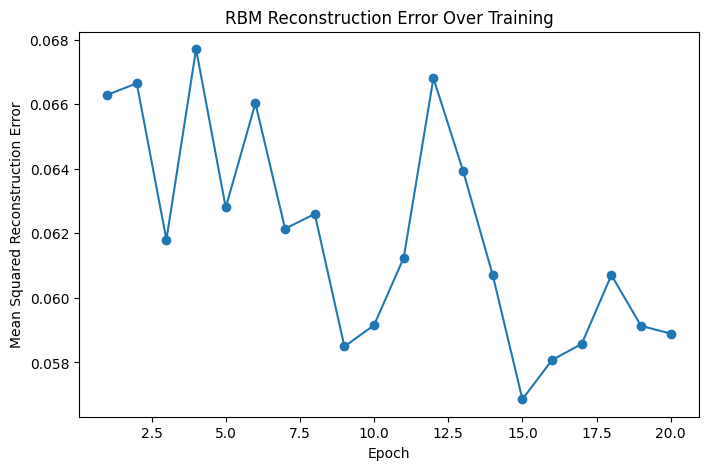

In [24]:
import matplotlib.pyplot as plt

# Function to calculate reconstruction error
def reconstruction_error(rbm, data, k=5):
    data = data.view(-1, 28*28)
    with torch.no_grad():
        reconstructed = rbm.gibbs_sampling(data, k=k)
    return ((data - reconstructed) ** 2).mean().item()

errors = []

# Training loop with reconstruction error tracking
epochs = 20
for epoch in range(epochs):
    for batch, _ in train_loader:
        batch = batch.view(-1, 28*28)
        rbm.contrastive_divergence(batch, lr=lr)
    # Evaluate reconstruction error on a fixed validation batch
    val_batch, _ = next(iter(train_loader))
    err = reconstruction_error(rbm, val_batch)
    errors.append(err)
    print(f"Epoch {epoch+1}, Reconstruction Error: {err:.4f}")

# Plot reconstruction error over epochs
plt.figure(figsize=(8,5))
plt.plot(range(1, epochs+1), errors, marker='o')
plt.xlabel("Epoch")
plt.ylabel("Mean Squared Reconstruction Error")
plt.title("RBM Reconstruction Error Over Training")
plt.show()


## References
[1] Hinton, G. E. (2002). Training products of experts by minimizing contrastive divergence. Neural Computation, 14(8), 1771–1800.

[2] Hinton, G. E., & Salakhutdinov, R. R. (2006). Reducing the dimensionality of data with neural networks. Science, 313(5786), 504–507.

[3] Fischer, A., & Igel, C. (2012). An introduction to restricted Boltzmann machines. In Progress in Pattern Recognition, Image Analysis, Computer Vision, and Applications (pp. 14–36). Springer.

[4] Ackley, D. H., Hinton, G. E., & Sejnowski, T. J. (1985). A learning algorithm for Boltzmann machines. Cognitive Science, 9(1), 147–169.

[5] Ising, E. (1925). Beitrag zur Theorie des Ferromagnetismus. Zeitschrift für Physik, 31(1), 253–258.
